In [1]:
import numpy as np
from numpy import random
import scipy as sp
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
 
from tqdm import tqdm_notebook as tqdm
from pathlib import Path
from IPython.display import display

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

from matplotlib import animation

# sns.set_context('talk')

# データ1
ローカルレベル＋回帰成分（回帰係数は一定）

In [2]:
n_sample = 50
a_sd = 1.8
b_sd = 1.0
y_sd = 1.2
a0 = 10.0
beta = 0.8

random.seed(4)

state = a0 + random.normal(0, a_sd, n_sample).cumsum()

base = random.normal(0, b_sd, n_sample).cumsum()
trend = np.repeat((0.1, -0.05, 0.1), (12, 20, 18))
x = base + trend

y = state + beta * x + random.normal(0, y_sd, n_sample)
idx = np.arange(n_sample)

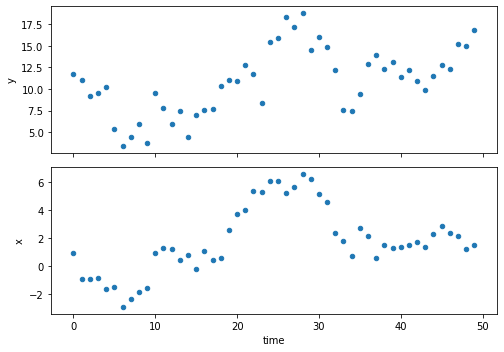

In [3]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(7, 5))

axes[0].scatter(idx, y, s=20)
axes[0].set_ylabel('y')
axes[1].scatter(idx, x, s=20)
axes[1].set_ylabel('x')
axes[1].set_xlabel('time')

plt.tight_layout()
plt.savefig('ts_data1.png')

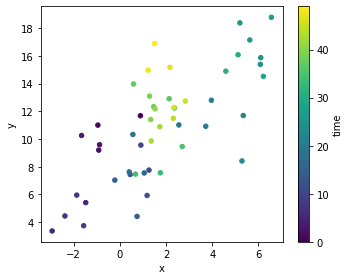

In [4]:
plt.figure(figsize=(5, 4))
plt.scatter(x, y, c=idx, s=20)
cb = plt.colorbar()
cb.set_label('time')
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.savefig('scatter_data1.png')

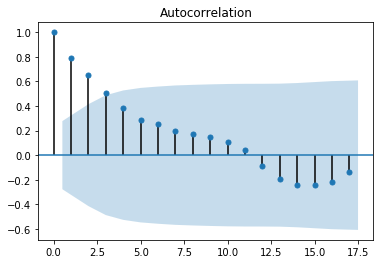

In [5]:
sm.tsa.graphics.plot_acf(y)
plt.show()

## Model1: オンライン線形回帰

In [6]:
def online_linear_regression(x, y):
    n_sample = len(x)
    res = []
    # 3時点目から予測可能
    for i in range(2, n_sample):
        x_sub, y_sub = x[:i], y[:i]

        slope, intercept, _, _, _ = stats.linregress(x_sub, y_sub)

        y_pred = x[i] * slope + intercept
        res.append((y_pred, slope, intercept))

    res_df = pd.DataFrame(res)
    res_df.columns = ['y_pred', 'slope', 'intercept']
    res_df.index = range(2, n_sample)
    return res_df

In [7]:
res_df = online_linear_regression(x, y)

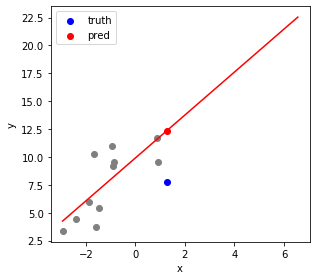

In [8]:
i = 11

xx = np.array([x.min(), x.max()])
yy = xx * res_df.slope[i] + res_df.intercept[i]

fig, ax = plt.subplots(figsize=(4.5, 4))
im1 = ax.scatter(x[:i], y[:i], color='gray')
im2, = ax.plot(xx, yy, c='r')
im3 = ax.scatter(x[i], y[i], c='b', label='truth')
im4 = ax.scatter(x[i], res_df.y_pred[i], c='r', label='pred')

ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.tight_layout()
plt.savefig(f'lr_pred_t{i}.png')

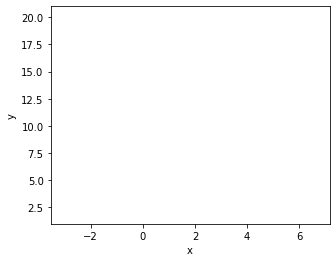

In [9]:
# ArtistAnimation

xx = np.array([x.min(), x.max()])

fig, ax = plt.subplots(figsize=(5, 4))
ims = []
for i in range(2, n_sample):
    yy = xx * res_df.slope[i] + res_df.intercept[i]
    
    im1 = ax.scatter(x[:i], y[:i], color='gray')
    im2, = ax.plot(xx, yy, c='r')
    im3 = ax.scatter(x[i], y[i], c='b', label='truth')
    im4 = ax.scatter(x[i], res_df.y_pred[i], c='r', label='pred')
    ims.append([im1, im2, im3, im4])
    
# ax.legend()
ax.set_ylim(np.floor(y.min()) - 2 , np.ceil(y.max()) + 2)
ax.set_xlabel('x')
ax.set_ylabel('y')

ani = animation.ArtistAnimation(fig, ims, interval=200)
ani.save("output_lr1.gif", writer='pillow')

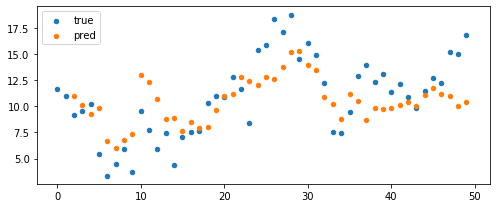

In [10]:
# fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# axes[0].scatter(idx, y, label='true')
# axes[0].scatter(idx[2:], res_df.y_pred, label='pred')
# axes[0].legend()
# axes[1].scatter(idx, x, marker='s')

fig, ax = plt.subplots(figsize=(7, 3))

ax.scatter(idx, y, s=20, label='true')
ax.scatter(idx[2:], res_df.y_pred, s=20, label='pred')
ax.legend()
plt.tight_layout()
plt.savefig('lr_pred.png')

## Model2: 状態空間モデル

In [11]:
mod = sm.tsa.UnobservedComponents(y, 'llevel', exog=x)
res = mod.fit()
res.summary()

preds = res.get_prediction()
res_df = preds.summary_frame()
res_df.columns = ['y_pred', 'pred_se', 'lwr', 'upr']
res_df['intercept'] = res.predicted_state[0, :n_sample]


xx = np.array([x.min(), x.max()])
slope = res.params[-1]

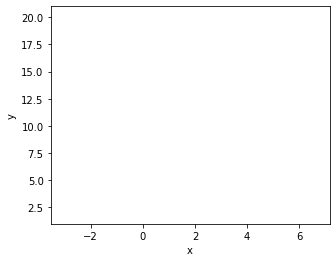

In [12]:
# ArtistAnimation
fig, ax = plt.subplots(figsize=(5, 4))
ims = []
for i in range(2, n_sample):
    yy = xx * slope + res_df.intercept[i]
    
    im1 = ax.scatter(x[:i], y[:i], color='gray')
    im2, = ax.plot(xx, yy, c='r')
    im3 = ax.scatter(x[i], y[i], c='b', label='truth')
    im4 = ax.scatter(x[i], res_df.y_pred[i], c='r', label='pred')
    ims.append([im1, im2, im3, im4])
    
# ax.legend()
ax.set_ylim(np.floor(y.min()) - 2 , np.ceil(y.max()) + 2)
ax.set_xlabel('x')
ax.set_ylabel('y')

ani = animation.ArtistAnimation(fig, ims, interval=200)
ani.save("output_ss1.gif", writer='pillow')

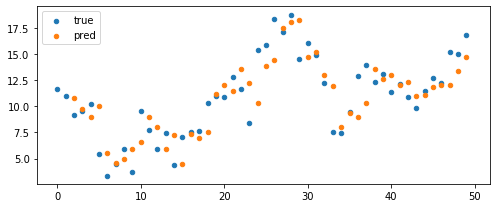

In [13]:
fig, ax = plt.subplots(figsize=(7, 3))

ax.scatter(idx, y, s=20, label='true')
ax.scatter(idx[2:], res_df.y_pred[2:], s=20, label='pred')
ax.legend()
plt.tight_layout()
plt.savefig('ss_pred.png')

# データ2
途中で切片が大きく変化する場合

In [14]:
n_sample = 100
a_sd = 0.6
b_sd = 1.0
y_sd = 0.9
a0 = 5.0
beta = 0.7

random.seed(1)

state = a0 + random.normal(0, a_sd, n_sample).cumsum()
# state = np.zeros(n_sample)
# state[0] = a0
# for i in range(n_sample-1):
#     state[i + 1] = stats.cauchy.rvs(loc=state[i], scale=a_sd, size=1)
    
base = random.normal(0, b_sd, n_sample).cumsum()
trend = np.repeat((0.1, -0.05, 0.1), (24, 40, 36))
x = base + trend

y = state + beta * x + random.normal(0, y_sd, n_sample)

# 外乱
period = np.zeros(n_sample, dtype=int)
period[30:] += 1
period[70:] += 1
period_dummy = pd.get_dummies(period, prefix='period', drop_first=True)

gamma = [8.0, -18.0]
y += period_dummy.dot(gamma)

# y[30:] += 8.0
# y[70:] -= 18.0
idx = np.arange(n_sample)

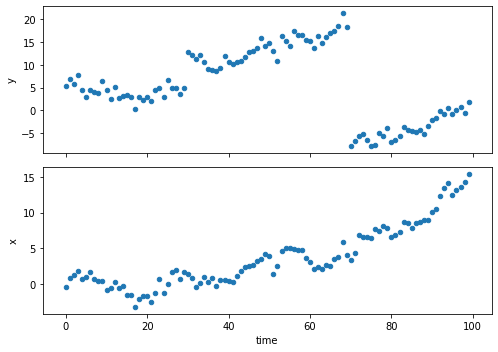

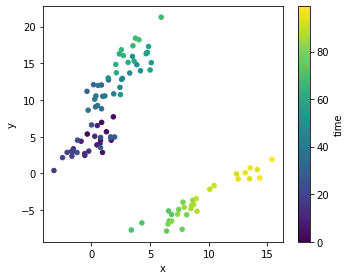

In [15]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(7, 5))

axes[0].scatter(idx, y, s=20)
axes[0].set_ylabel('y')
axes[1].scatter(idx, x, s=20)
axes[1].set_ylabel('x')
axes[1].set_xlabel('time')

plt.tight_layout()
plt.savefig('ts_data2.png')

plt.figure(figsize=(5, 4))
plt.scatter(x, y, c=idx, s=20)
cb = plt.colorbar()
cb.set_label('time')
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.savefig('scatter_data2.png')

## Model1: オンライン線形回帰
t時点のyの予測にt時点までのxとt-1時点までのyを利用。

In [16]:
res = []
# y_3から予測可能
for i in range(2, n_sample):
    x_sub, y_sub = x[:i], y[:i]

    slope, intercept, _, _, _ = stats.linregress(x_sub, y_sub)

    y_pred = x[i] * slope + intercept
    res.append((y_pred, slope, intercept))

In [17]:
res_df = pd.DataFrame(res)
res_df.columns = ['y_pred', 'slope', 'intercept']
res_df.index = range(2, n_sample)

In [18]:
# FuncAnimation
# def update(i):
#     yy = xx * res_df.slope[i] + res_df.intercept[i]
#     im1 = ax.scatter(x[:i], y[:i], color='gray')
#     im2, = ax.plot(xx, yy, c='r')
#     im3 = ax.scatter(x[i], y[i], c='b', label='truth')
#     im4 = ax.scatter(x[i], res_df.y_pred[i], c='r', label='pred')
#     return im1, im2, im3, im4

# fig, ax = plt.subplots(figsize=(5, 4))
# ani = animation.FuncAnimation(fig, update, range(2, n_sample))
# ani.save("output_lr2.gif", writer="pillow")

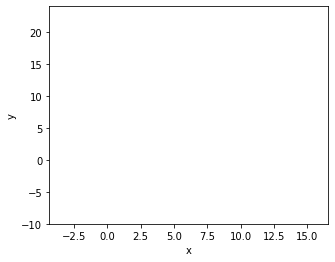

In [19]:
# ArtistAnimation

xx = np.array([x.min(), x.max()])

fig, ax = plt.subplots(figsize=(5, 4))
ims = []
for i in range(2, n_sample):
    yy = xx * res_df.slope[i] + res_df.intercept[i]
    
    im1 = ax.scatter(x[:i], y[:i], color='gray')
    im2, = ax.plot(xx, yy, c='r')
    im3 = ax.scatter(x[i], y[i], c='b', label='truth')
    im4 = ax.scatter(x[i], res_df.y_pred[i], c='r', label='pred')
    ims.append([im1, im2, im3, im4])
    
# ax.legend()
ax.set_ylim(np.floor(y.min()) - 2 , np.ceil(y.max()) + 2)
ax.set_xlabel('x')
ax.set_ylabel('y')

ani = animation.ArtistAnimation(fig, ims, interval=200)
ani.save("output_lr2.gif", writer='pillow')

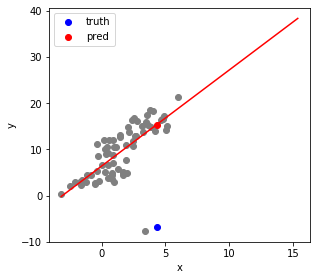

In [20]:
i = 71

xx = np.array([x.min(), x.max()])
yy = xx * res_df.slope[i] + res_df.intercept[i]

fig, ax = plt.subplots(figsize=(4.5, 4))
im1 = ax.scatter(x[:i], y[:i], color='gray')
im2, = ax.plot(xx, yy, c='r')
im3 = ax.scatter(x[i], y[i], c='b', label='truth')
im4 = ax.scatter(x[i], res_df.y_pred[i], c='r', label='pred')

ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.tight_layout()
plt.savefig(f'lr_pred2_t{i}.png')

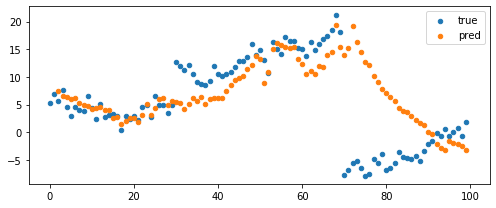

In [21]:
fig, ax = plt.subplots(figsize=(7, 3))

ax.scatter(idx, y, s=20, label='true')
ax.scatter(idx[2:], res_df.y_pred, s=20, label='pred')
ax.legend()
plt.tight_layout()
plt.savefig('lr_pred2.png')

## 状態空間モデル

### ローカルレベル＋回帰成分(係数固定）

In [22]:
mod = sm.tsa.UnobservedComponents(y, 'llevel', exog=x)
# mod = sm.tsa.UnobservedComponents(y, 'llevel', mle_regression=False, exog=x)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Unobserved Components Results                         
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                    local level   Log Likelihood                -248.620
Date:                Mon, 06 Jan 2020   AIC                            503.240
Time:                        23:20:27   BIC                            511.025
Sample:                             0   HQIC                           506.390
                                - 100                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular     0.4667      1.960      0.238      0.812      -3.376       4.309
sigma2.level         7.9795      3.562      2.240      0.025       0.997      14.962
beta.x1              1.1421      0.630      1.814      0.070      -0.092       2.376
===================================================================================
Ljung-Box (Q):                       28.72   Jarque-Bera (JB):             10118.11
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               5.53   Skew:                            -5.74
Prob(H) (two-sided):                  0.00   Kurtosis:                        51.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [23]:
preds = res.get_prediction()
res_df = preds.summary_frame()
res_df.columns = ['y_pred', 'pred_se', 'lwr', 'upr']
res_df['intercept'] = res.predicted_state[0, :n_sample]

# pred_mean = pred_res['mean']
# lwr = pred_res['mean_ci_lower']
# upr = pred_res['mean_ci_upper']

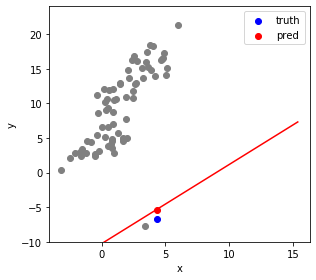

In [24]:
i = 71

xx = np.array([x.min(), x.max()])
slope = res.params[-1]

fig, ax = plt.subplots(figsize=(4.5, 4))
yy = xx * slope + res_df.intercept[i]

im1 = ax.scatter(x[:i], y[:i], color='gray')
im2, = ax.plot(xx, yy, c='r')
im3 = ax.scatter(x[i], y[i], c='b', label='truth')
im4 = ax.scatter(x[i], res_df.y_pred[i], c='r', label='pred')
    
ax.legend()
ax.set_ylim(np.floor(y.min()) - 2 , np.ceil(y.max()) + 2)
ax.set_xlabel('x')
ax.set_ylabel('y')

plt.tight_layout()
plt.savefig(f'ss_pred2_t{i}.png')

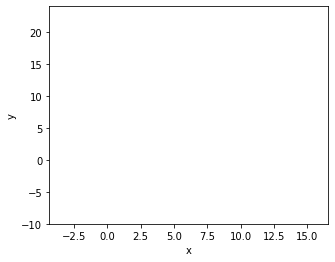

In [25]:
# ArtistAnimation
xx = np.array([x.min(), x.max()])
slope = res.params[-1]

fig, ax = plt.subplots(figsize=(5, 4))
ims = []
for i in range(2, n_sample):
    yy = xx * slope + res_df.intercept[i]
    
    im1 = ax.scatter(x[:i], y[:i], color='gray')
    im2, = ax.plot(xx, yy, c='r')
    im3 = ax.scatter(x[i], y[i], c='b', label='truth')
    im4 = ax.scatter(x[i], res_df.y_pred[i], c='r', label='pred')
    ims.append([im1, im2, im3, im4])
    
# ax.legend()
ax.set_ylim(np.floor(y.min()) - 2 , np.ceil(y.max()) + 2)
ax.set_xlabel('x')
ax.set_ylabel('y')

ani = animation.ArtistAnimation(fig, ims, interval=200)
ani.save("output_ss.gif", writer='pillow')

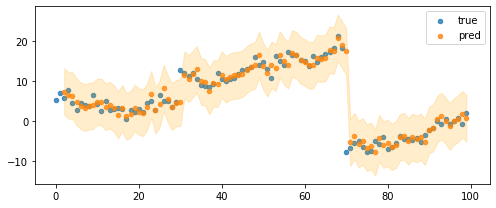

In [26]:
fig, ax = plt.subplots(figsize=(7, 3))

n_omit = 2
ax.scatter(idx, y, s=20, alpha=0.8, label='true')
ax.scatter(idx[n_omit:], res_df.y_pred[n_omit:], s=20, alpha=0.8, label='pred')
ax.fill_between(idx[n_omit:], res_df.lwr[n_omit:], res_df.upr[n_omit:], color='orange', alpha=0.2)
ax.legend()
plt.tight_layout()
plt.savefig('ss_pred2.png')

### 時変係数モデル

In [27]:
mod = sm.tsa.UnobservedComponents(y, 'llevel', mle_regression=False, exog=x)
res = mod.fit()
display(res.summary())

preds = res.get_prediction()
res_df = preds.summary_frame()
res_df.columns = ['y_pred', 'pred_se', 'lwr', 'upr']
res_df['intercept'] = res.predicted_state[0, :n_sample]
res_df['slope'] = res.predicted_state[1, :n_sample]

res_df.head()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Unobserved Components Results                         
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                    local level   Log Likelihood                -248.650
Date:                Mon, 06 Jan 2020   AIC                            501.301
Time:                        23:20:41   BIC                            506.471
Sample:                             0   HQIC                           503.392
                                - 100                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular     0.4724      1.790      0.264      0.792      -3.037       3.982
sigma2.level         8.0588      3.302      2.441      0.015       1.588      14.530
===================================================================================
Ljung-Box (Q):                       27.95   Jarque-Bera (JB):              9689.54
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               5.32   Skew:                            -5.67
Prob(H) (two-sided):                  0.00   Kurtosis:                        50.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

,y_pred,pred_se,lwr,upr,intercept,slope
0,0.000000,1058.536118,-2074.692667,2074.692667,0.000000,0.000000
1,3.333399,1156.797514,-2263.948065,2270.614864,4.793247,-1.663873
2,7.488064,3.208213,1.200082,13.776047,5.822289,1.300502
3,6.243397,3.313713,-0.251360,12.738155,4.729894,0.807439
4,6.294579,3.716621,-0.989865,13.579022,5.326068,1.242417


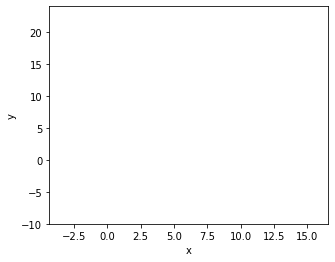

In [28]:
# ArtistAnimation

xx = np.array([x.min(), x.max()])

fig, ax = plt.subplots(figsize=(5, 4))
ims = []
for i in range(2, n_sample):
    yy = xx * res_df.slope[i] + res_df.intercept[i]
    
    im1 = ax.scatter(x[:i], y[:i], color='gray')
    im2, = ax.plot(xx, yy, c='r')
    im3 = ax.scatter(x[i], y[i], c='b', label='truth')
    im4 = ax.scatter(x[i], res_df.y_pred[i], c='r', label='pred')
    ims.append([im1, im2, im3, im4])
    
# ax.legend()
ax.set_ylim(np.floor(y.min()) - 2 , np.ceil(y.max()) + 2)
ax.set_xlabel('x')
ax.set_ylabel('y')

ani = animation.ArtistAnimation(fig, ims, interval=200)
ani.save("output_ss3.gif", writer='pillow')

時々状態が大きく変化するため、過程誤差分散が大きく推定されてしまう。
変化点が既知の場合は説明変数として与えれば良い。未知の場合はコーシー分布を使ったモデリングが考えられる。

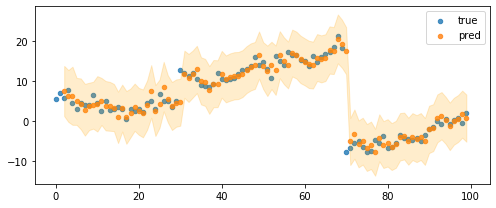

In [29]:
fig, ax = plt.subplots(figsize=(7, 3))

n_omit = 2
ax.scatter(idx, y, s=20, alpha=0.8, label='true')
ax.scatter(idx[n_omit:], res_df.y_pred[n_omit:], s=20, alpha=0.8, label='pred')
ax.fill_between(idx[n_omit:], res_df.lwr[n_omit:], res_df.upr[n_omit:], color='orange', alpha=0.2)
ax.legend()
plt.tight_layout()
plt.savefig('ss_pred3.png')

### 変化点を説明変数で表現

In [30]:
exog = period_dummy.copy()
exog['x'] = x
exog.head()

,period_1,period_2,x
0,0,0,-0.347129
1,0,0,0.877379
2,0,0,1.280871
3,0,0,1.874449
4,0,0,0.779537


In [31]:
mod = sm.tsa.UnobservedComponents(y, 'llevel', exog=exog)
# mod = sm.tsa.UnobservedComponents(y, 'llevel', mle_regression=False, exog=x)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Unobserved Components Results                         
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                    local level   Log Likelihood                -156.173
Date:                Mon, 06 Jan 2020   AIC                            322.346
Time:                        23:20:51   BIC                            335.321
Sample:                             0   HQIC                           327.596
                                - 100                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular     0.8128      0.151      5.397      0.000       0.518       1.108
sigma2.level         0.2248      0.097      2.307      0.021       0.034       0.416
beta.period_1        7.6839      3.263      2.355      0.019       1.288      14.080
beta.period_2      -18.2844      4.175     -4.380      0.000     -26.466     -10.102
beta.x               0.8743      0.119      7.332      0.000       0.641       1.108
===================================================================================
Ljung-Box (Q):                       48.66   Jarque-Bera (JB):                 0.05
Prob(Q):                              0.16   Prob(JB):                         0.98
Heteroskedasticity (H):               0.74   Skew:                            -0.05
Prob(H) (two-sided):                  0.38   Kurtosis:                         2.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### コーシー分布の利用
状態方程式にコーシー分布を利用し、変化点を表現。

In [1]:
# pystan
stan_code = '''

data {
  int N;
  real Y[N];
  real X[N];
}

parameters {
  real mu0;
  real<lower=0> s_mu;
  real<lower=-pi()/2, upper=pi()/2> mu_unif[N-1];
  real<lower=0> s_y;
  real beta;
}

transformed parameters {
  real mu[N];
  mu[1] = mu0;
  for (n in 2:N)
    mu[n] = mu[n-1] + s_mu * tan(mu_unif[n-1]);
    z[n] = mu[n] + beta * X[n];
}

model {
  for (n in 1:N)
    Y[n] ~ normal(z[n], s_y);
}


'''


In [ ]:
from pystan import StanModel

stan_model = StanModel(model_code=stan_code)

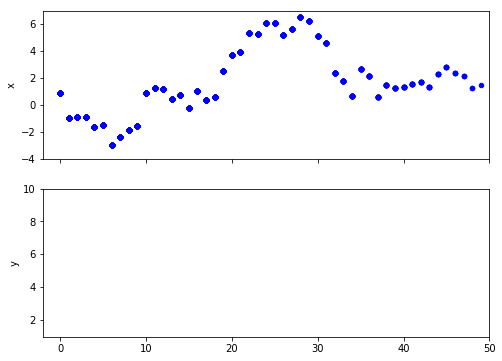

In [13]:
from matplotlib import animation

# for i in range(n_sample):
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)


def update(i):
    plt.cla()
#     i =39 # 観測ずみのxのid
    idx = np.arange(i+1)

    axes[0].scatter(idx, x[idx], s=20, color='b')
    axes[1].scatter(idx[:-1], y[idx[:-1]], s=20, color='b')

    if i  > missing_id.min():
        tmp_id = np.arange(missing_id.min(), i)    
        axes[1].scatter(tmp_id, y_ori[tmp_id], marker='x', color='gray', alpha=0.4, s=20)

    axes[1].scatter(idx[n_omit:-1], pred_mean[idx[n_omit:-1]], s=10, color='r', marker='s', alpha=0.5)
    axes[1].scatter(i , pred_mean[i ], color='r', marker='s')
    axes[1].fill_between(idx[n_omit:], lwr[n_omit:i+1], upr[n_omit:i+1], color='r', alpha=0.1)
    
    axes[0].set_xlim(-2, n_sample)
    axes[0].set_ylim(-4, 7)
    axes[1].set_ylim(1, 10)
    axes[0].set_ylabel('x')
    axes[1].set_ylabel('y')
#     ims.append(fig)
#     plt.close()

ani = animation.FuncAnimation(fig, update, n_sample, interval=500)
ani.save("StateSpacePred.gif", writer = 'pillow')

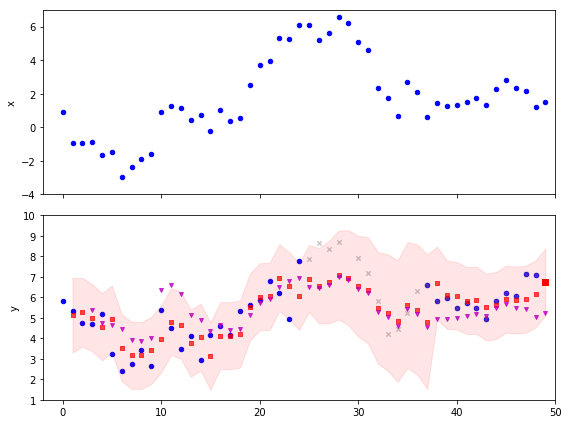

In [14]:
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

i = 49

idx = np.arange(i+1)

axes[0].scatter(idx, x[idx], s=20, color='b')
axes[1].scatter(idx[:-1], y[idx[:-1]], s=20, color='b')

if i  > missing_id.min():
    tmp_id = np.arange(missing_id.min(), i)    
    axes[1].scatter(tmp_id, y_ori[tmp_id], marker='x', color='gray', alpha=0.4, s=20)

axes[1].scatter(idx[n_omit:-1], pred_mean[idx[n_omit:-1]], s=10, color='r', marker='s', alpha=0.7)
axes[1].scatter(i , pred_mean[i ], color='r', marker='s')
axes[1].fill_between(idx[n_omit:], lwr[n_omit:i+1], upr[n_omit:i+1], color='r', alpha=0.1)

# linear regression
axes[1].scatter(idx[3:], y_preds, marker='v', color='m', s=15, alpha=0.8)

axes[0].set_xlim(-2, n_sample)
axes[0].set_ylim(-4, 7)
axes[1].set_ylim(1, 10)
axes[0].set_ylabel('x')
axes[1].set_ylabel('y')

plt.tight_layout()
# plt.savefig('pred_res.png')

途中に外乱を入れてみる。

In [47]:
n_sample = 50
a_sd = 0.6
b_sd = 1.0
y_sd = 0.6
a0 = 5.0
beta = 0.8

random.seed(5)

state = a0 + random.normal(0, a_sd, n_sample).cumsum()

base = random.normal(0, b_sd, n_sample).cumsum()
trend = np.repeat((0.1, -0.05, 0.1), (12, 20, 18))
x = base + trend

y = state + beta * x + random.normal(0, y_sd, n_sample)

#  外乱
y[20:] += 8.0

# y_ori[25:] -= 1.0
# y = y_ori.copy()

# missing_id = np.arange(25, 37)
# y[missing_id] = np.nan

idx = np.arange(n_sample)

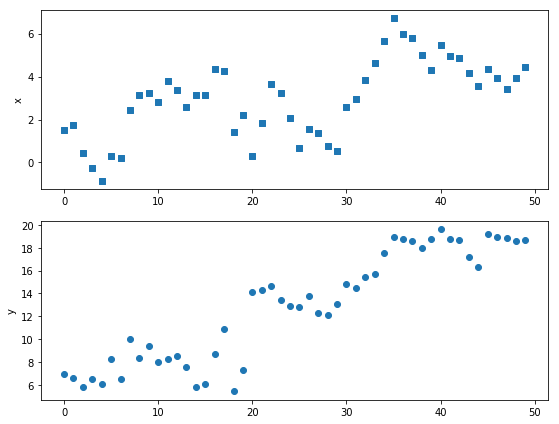

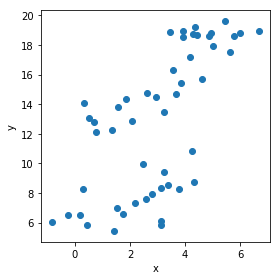

In [48]:
fig, axes = plt.subplots(2, 1, figsize=(8, 6))

axes[0].scatter(idx, x, marker='s')
axes[0].set_ylabel('x')
axes[1].scatter(idx, y)
axes[1].set_ylabel('y')

plt.tight_layout()
plt.savefig('time_series.png')
# axes[1].scatter(missing_id, y_ori[missing_id])

plt.figure(figsize=(4, 4))
plt.scatter(x, y)
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.savefig('x_y_scatter.png')

In [49]:
y_preds = []

for i in range(2, n_sample-1):
    isnan = np.isnan(x[:i]) | np.isnan(y[:i])
    x_comp, y_comp = x[:i][~isnan], y[:i][~isnan]

    slope, intercept, _, _, _ = stats.linregress(x_comp, y_comp)

    y_pred = x[i + 1] * slope + intercept
    y_preds.append(y_pred)

In [50]:
mod = sm.tsa.UnobservedComponents(y, 'llevel', exog=x)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Unobserved Components Results                         
==============================================================================
Dep. Variable:                      y   No. Observations:                   50
Model:                    local level   Log Likelihood                 -92.120
Date:                Wed, 06 Nov 2019   AIC                            190.240
Time:                        15:06:50   BIC                            195.916
Sample:                             0   HQIC                           192.393
                                 - 50                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular     0.6645      0.411      1.619      0.106      -0.140       1.469
sigma2.level         1.3578      0.685      1.983      0.047       0.016       2.700
beta.x1              0.6660      0.226      2.948      0.003       0.223       1.109
===================================================================================
Ljung-Box (Q):                       23.65   Jarque-Bera (JB):               314.83
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.57   Skew:                             2.47
Prob(H) (two-sided):                  0.27   Kurtosis:                        14.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

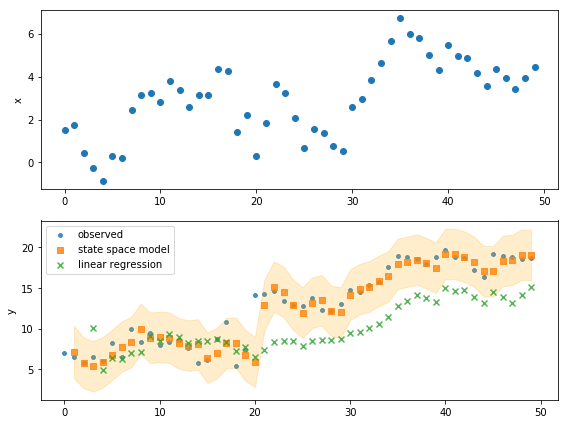

In [58]:
preds = res.get_prediction()
pred_res = preds.summary_frame()
pred_mean = pred_res['mean']
lwr = pred_res['mean_ci_lower']
upr = pred_res['mean_ci_upper']


n_omit = 1
idx = np.arange(n_sample)

fig, axes = plt.subplots(2, 1, figsize=(8, 6))

axes[0].scatter(idx, x)
axes[0].set_ylabel('x')
axes[1].scatter(idx, y, s=15, label='observed', alpha=0.8)
# axes[1].scatter(missing_id, y_ori[missing_id], c='gray', s=15)
axes[1].scatter(idx[n_omit:], pred_mean[n_omit:], marker='s',  label='state space model', alpha=0.8)
axes[1].fill_between(idx[n_omit:], lwr[n_omit:], upr[n_omit:], color='orange', alpha=0.2)
axes[1].scatter(idx[3:], y_preds, marker='x', label='linear regression', alpha=0.8)
axes[1].legend()
axes[1].set_ylabel('y')

plt.tight_layout()
plt.savefig('time_series_pred.png')

## 複数の成分に分解可能
トレンド、周期、水準

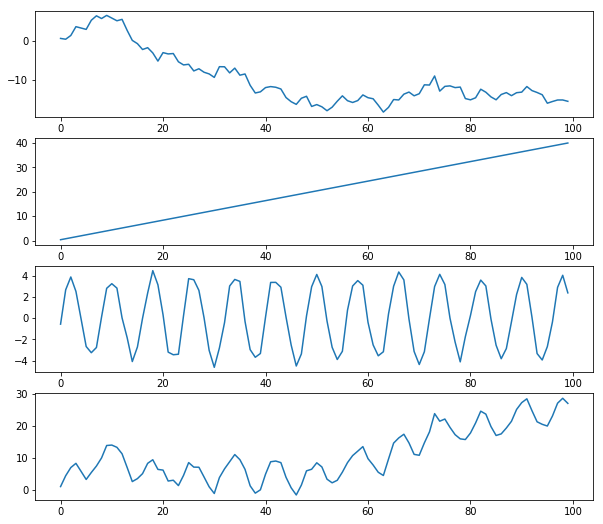

In [29]:
n_sample = 100
trend = 0.4
b_season = 4.0

sig_level = 1.5
sig_obs = 1.0
sig_trend = 0.8
sig_season = 0.4

periodic = 8

random.seed(42)

level = random.normal(scale=sig_level, size=n_sample).cumsum()

# trend = random.normal(trend, sig_trend, n_sample).cumsum()
trend = np.repeat(trend, n_sample).cumsum()

seasonal = b_season * np.sin(2 * np.pi * np.arange(n_sample) / periodic) + random.normal(scale=sig_season, size=n_sample)

noise = random.normal(scale=sig_obs)

y = level + trend + seasonal + noise

fig, axes = plt.subplots(4, 1, figsize=(10, 9))
axes[0].plot(level)
axes[1].plot(trend)
axes[2].plot(seasonal)
axes[3].plot(y)

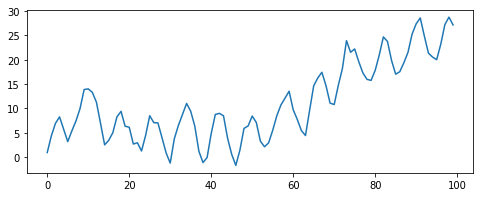

In [42]:
plt.figure(figsize=(8, 3))
plt.plot(y)
# plt.plot(y, marker='.', ls='')
plt.savefig('ts_trend_season.png')

In [30]:
mod = sm.tsa.UnobservedComponents(y, level=True, trend=True, stochastic_level=True, stochastic_trend=True, seasonal=periodic)
# tmp = mod.fit(method='powell')
# res = mod.fit(start_params=tmp.params)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Unobserved Components Results                            
====================================================================================
Dep. Variable:                            y   No. Observations:                  100
Model:                                 None   Log Likelihood                -175.185
                   + stochastic seasonal(8)   AIC                            356.370
Date:                      Wed, 06 Nov 2019   BIC                            363.903
Time:                              15:00:45   HQIC                           359.409
Sample:                                   0                                         
                                      - 100                                         
Covariance Type:                        opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
sigma2.level        2.2062      0.307      7.181      0.000       1.604       2.808
sigma2.trend     8.383e-12      0.004   1.92e-09      1.000      -0.009       0.009
sigma2.seasonal  4.498e-11      0.011   4.26e-09      1.000      -0.021       0.021
===================================================================================
Ljung-Box (Q):                       41.95   Jarque-Bera (JB):                 0.86
Prob(Q):                              0.39   Prob(JB):                         0.65
Heteroskedasticity (H):               0.65   Skew:                            -0.18
Prob(H) (two-sided):                  0.24   Kurtosis:                         3.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

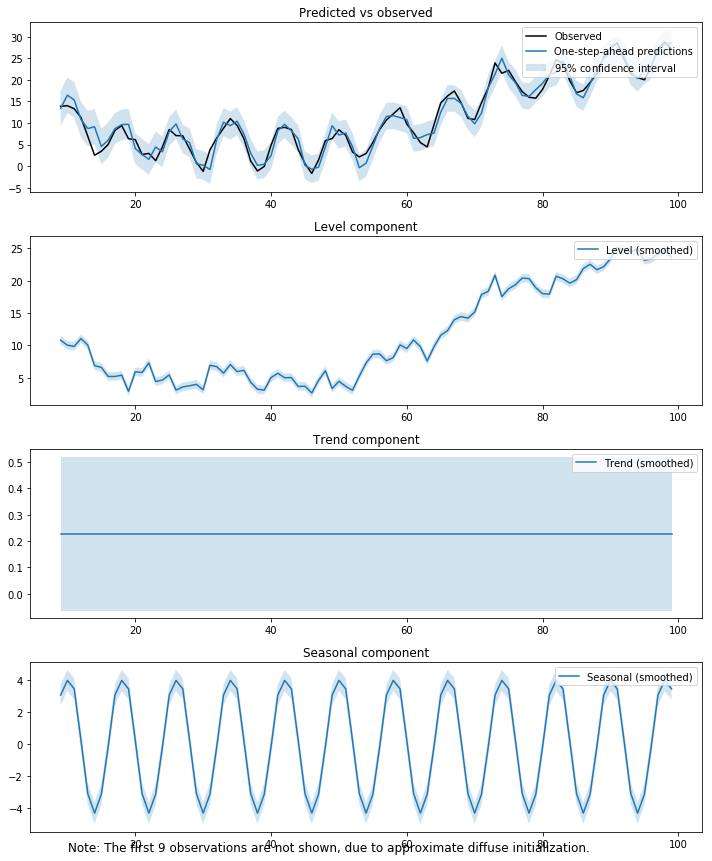

In [31]:
# fig, ax = plt.subplot()
res.plot_components(figsize=(10, 12))
plt.tight_layout()
plt.savefig('trend_seasonal_smoothed.png')
plt.show()